# Speak Feel: Model Building and Evaluation   

**Bach Le, Kien Tran, Sauryanshu Khanal, Sike Ogieva**

Emotion Recognition has important applications in natural language processing and human computer interaction.
Here, we build and train a neural network to classify human speech data by emotion.   

Dataset:   
https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio?resource=download

Project Milestones:   
https://github.com/sauryanshu55/Speech-Recognition 

---

**Imports and Helper Functions**

In [35]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
    classification_report,
)
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import ( 
    Activation,
    BatchNormalization,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    LSTM,
    MaxPool1D,
    MaxPooling1D,  
)
from tensorflow.keras.utils import to_categorical

In [2]:
emotion_list = {
    0: "neutral",
    1: "calm",
    2: "happy",
    3: "sad",
    4: "angry",
    5: "fearful",
    6: "disgusted",
    7: "surprised",
}


def extract_mfcc(audio):
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=40).T, axis=0)
    return mfccs


def plot_network_history(network_history):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    axes[0].plot(network_history.history["loss"], label="Training Loss")
    axes[0].plot(network_history.history["val_loss"], label="Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].plot(network_history.history["accuracy"], label="Training Accuracy")
    axes[1].plot(network_history.history["val_accuracy"], label="Validation Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.show()

**Load The Data**

Earlier, we augmented the training audio files from 1_152 files to 12_000 files, and now we load them and their labels along with 288 test data files (and their labels) to begin building, training and evaluating our models.
We begin by extracting Mel-Frequency Cepstral Coefficients from the audio files, and categorically encoding the labels.

In [3]:
# load the augmented data from my computer
with open("./data/processed_data.pickle", "rb") as f:
    data = pickle.load(f)
    
X_train = data['X_train']
X_test  = data['X_test']
Y_train = data['Y_train']
Y_test  = data['Y_test']

In [4]:
# extract mfccs from the audio files
X_train = np.array([extract_mfcc(audio) for audio in X_train])
X_test  = np.array([extract_mfcc(audio) for audio in X_test])

# categorically encode the labels
Y_train, Y_test = to_categorical(Y_train), to_categorical(Y_test)

In [5]:
print(f'Training data size: {len(X_train)} data points * {len(X_train[0])} MFCCs.')
print(f'Testing  data size: {len(X_test)}    data points * {len(X_train[0])} MFCCs.')
print()

print(f'Training label size: {len(Y_train)} data points * {len(Y_train[0])} categories.')
print(f'Testing  label size: {len(Y_test)}   data points * {len(Y_train[0])} categories.')

Training data size: 12000 data points * 40 MFCCs.
Testing  data size: 288  data points * 40 MFCCs.

Training label size: 12000 data points * 8 categories.
Testing  label size: 288 data points * 8 categories.


## Baseline Model: K Nearest Neighbours

The first model we build is a kNN. We start by running cross validation to select the best number of neighbours to train on. Then we go ahead to build the kNN, fit the model and evaluate it.
Accuracy has turned out to be 55%. While not impressive, this is much better than a random classifier whose accuracy we would expect to be around 1/8 or 12.5%.

In [6]:
# find the best k to train on
k_values = [1, 3, 5, 10, 20, 50, 150, 175, 200, 300, 500, 800, 1000]
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

f1_scores = [] 
for k in k_values:
    f1 = cross_val_score(
                    estimator = KNeighborsClassifier(n_neighbors = k), 
                    X = X_train, 
                    y = Y_train, 
                    cv = kf, 
                    scoring ='f1_macro') # macro for a multidimensional prediction
    mean_f1 = np.mean(f1)
    f1_scores.append(mean_f1)

best_index = f1_scores.index(max(f1_scores))
best_k = k_values[best_index]
print(f"The best k value is {best_k} with an average F1 score of {f1_scores[best_index]:.2f}")

The best k value is 1 with an average F1 score of 0.58


In [7]:
# train our knn model and use it to predict the test data
knn_classifier = KNeighborsClassifier(n_neighbors = 1) # k selected via above analysis
knn_classifier.fit(X_train, Y_train)
Y_pred = knn_classifier.predict(X_test)

In [8]:
# evaluate the model
y_pred_labels = Y_pred.argmax(axis=1)
y_test_labels = Y_test.argmax(axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='macro')
recall = recall_score(y_test_labels, y_pred_labels, average='macro')
f1 = f1_score(y_test_labels, y_pred_labels, average='macro')

knn = f1 # for future analysis

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

Accuracy : 0.5486111111111112
Precision: 0.554558566083482
Recall   : 0.5537603669830417
F1 Score : 0.5469946411838866


In [9]:
print(classification_report(y_test_labels, y_pred_labels, target_names = emotion_list.values()))

              precision    recall  f1-score   support

     neutral       0.48      0.70      0.57        20
        calm       0.71      0.75      0.73        40
       happy       0.41      0.47      0.44        34
         sad       0.62      0.42      0.50        38
       angry       0.54      0.56      0.55        39
     fearful       0.62      0.45      0.53        33
   disgusted       0.57      0.53      0.55        38
   surprised       0.48      0.54      0.51        46

    accuracy                           0.55       288
   macro avg       0.55      0.55      0.55       288
weighted avg       0.56      0.55      0.55       288



---
## Multi Layer Perceptron

The first neural network we will build is a fully-connected feed-forward network. MLPs are good at capturing interactions between features at a global level. They are also versatile and adaptable, and their ability to solve our problem is worth exploring.

In [10]:
# global neural network variables
num_classes = len(Y_test[0])

In [11]:
# build model
mlp_model = Sequential()

layers = [ 
    Input(shape = (len(X_train[0],))),
    
    Dense(256, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.3), 
    
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.3), 
    
    Dense(32, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    
    Dense(num_classes, activation='softmax'),
]

mlp_model = tf.keras.Sequential(layers)
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
mlp_model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               10496     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)            

Epoch 1/100


150/150 [==============================] - 4s 6ms/step - loss: 2.1499 - accuracy: 0.2034 - val_loss: 2.3134 - val_accuracy: 0.2079
Epoch 2/100
150/150 [==============================] - 1s 4ms/step - loss: 1.8930 - accuracy: 0.2612 - val_loss: 1.7599 - val_accuracy: 0.3187
Epoch 3/100
150/150 [==============================] - 1s 5ms/step - loss: 1.8208 - accuracy: 0.2890 - val_loss: 1.7342 - val_accuracy: 0.3296
Epoch 4/100
150/150 [==============================] - 1s 4ms/step - loss: 1.7702 - accuracy: 0.3198 - val_loss: 1.6873 - val_accuracy: 0.3450
Epoch 5/100
150/150 [==============================] - 1s 5ms/step - loss: 1.7135 - accuracy: 0.3427 - val_loss: 1.6701 - val_accuracy: 0.3575
Epoch 6/100
150/150 [==============================] - 1s 5ms/step - loss: 1.6784 - accuracy: 0.3624 - val_loss: 1.6698 - val_accuracy: 0.3533
Epoch 7/100
150/150 [==============================] - 1s 6ms/step - loss: 1.6541 - accuracy: 0.3688 - val_loss: 1.6172 - val_accuracy: 0.38

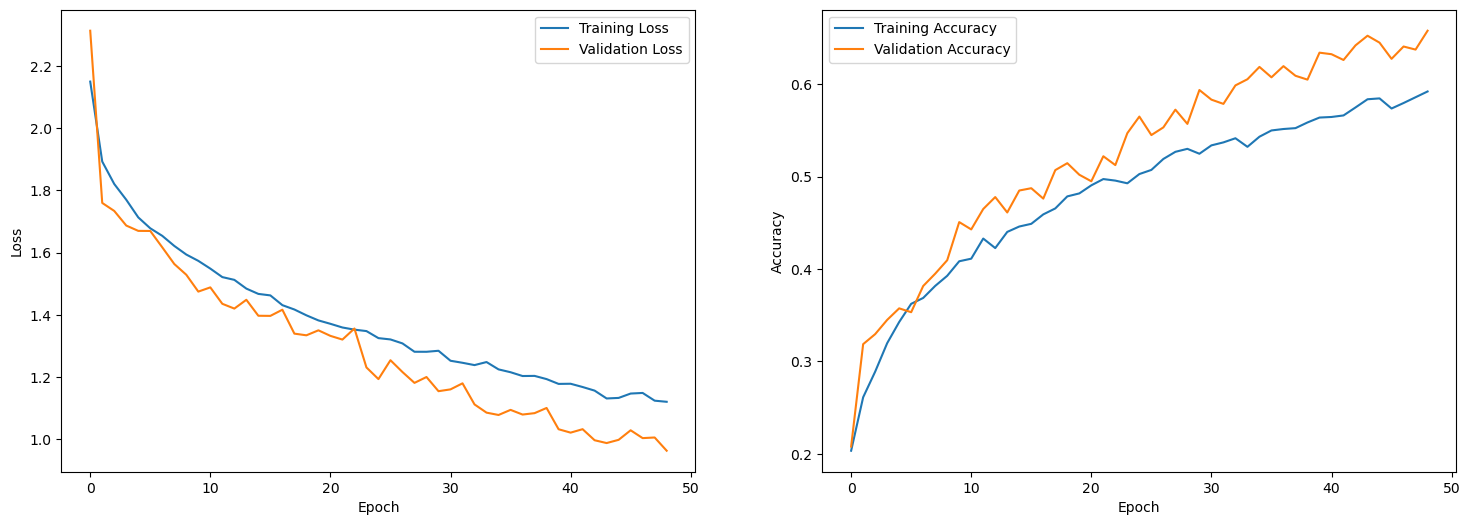

In [12]:
# callbacks
es = keras.callbacks.EarlyStopping(
    monitor="val_categorical_accuracy",
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

# train model
network_history = mlp_model.fit( 
    X_train, 
    Y_train, 
    epochs = 100,
    validation_split = 0.2,
    batch_size = 64,
    callbacks = [es]
)

# observe the training
plot_network_history(network_history)

In [13]:
# evaluate model
y_pred = np.argmax(mlp_model.predict(X_test), 1)
y_true = np.argmax(Y_test, 1)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

mlp = f1 # for future analysis

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

print()
print('Classification Report')
print(classification_report(y_true, y_pred, target_names = emotion_list.values()))

9/9 [==============================] - 0s 2ms/step
Accuracy : 0.5555555555555556
Precision: 0.5479529360725481
Recall   : 0.5287372518897623
F1 Score : 0.5223303904402377

Classification Report
              precision    recall  f1-score   support

     neutral       0.48      0.70      0.57        20
        calm       0.71      0.75      0.73        40
       happy       0.41      0.47      0.44        34
         sad       0.62      0.42      0.50        38
       angry       0.54      0.56      0.55        39
     fearful       0.62      0.45      0.53        33
   disgusted       0.57      0.53      0.55        38
   surprised       0.48      0.54      0.51        46

    accuracy                           0.55       288
   macro avg       0.55      0.55      0.55       288
weighted avg       0.56      0.55      0.55       288



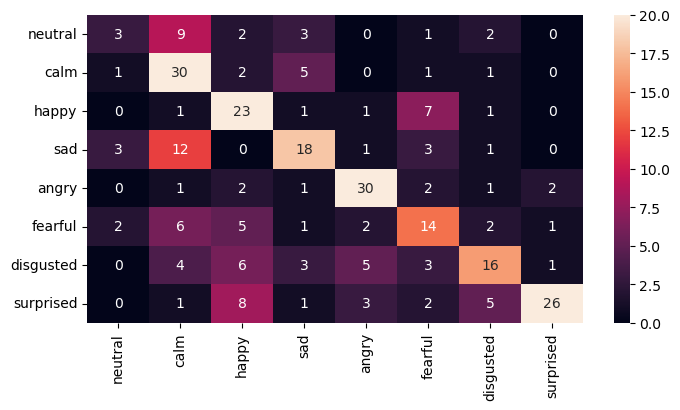

In [14]:
# confusion matrix
plt.figure(figsize=(8, 4))
conf = confusion_matrix(y_true, y_pred)
labels = emotion_list.values()
sns.heatmap(conf, annot=True, fmt="d", vmax=20, xticklabels=labels, yticklabels=labels)
plt.show()

---
## Convolutional Neural Network

Convolutional neural networks use filters to process data in a grid-like topology. While they are common with image classification problems, we hope to leverage their ability to discern context and locality to identify temporal and frequency-related properties inherent in sound data.

We start by transforming our data from the two dimensional [samples * features] to [samples, features, 1]. CNN layers expect this third dimension explicitly, even if it's just a single channel.

In [15]:
# add an extra dimension to our data
X_train = np.expand_dims(X_train, -1)
X_test  = np.expand_dims(X_test, -1)

In [27]:
cnn_model = Sequential()

layers = [
    Input(shape=(X_train.shape[1], X_train.shape[2])),
     
    Conv1D(32, kernel_size=(3), activation='relu', padding='same'),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.25),
    
    Conv1D(64, kernel_size=(3), activation='relu', padding='same'),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.25),
    
    Conv1D(64, kernel_size=(3), activation='relu', padding='same'),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.25),

    Conv1D(128, kernel_size=(3), activation='relu', padding='same'),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.4),
    
    Conv1D(128, kernel_size=(3), activation='relu', padding='same'),
    MaxPooling1D(pool_size=(2)),
    Dropout(0.4),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(num_classes, activation="softmax"),
]

cnn_model = tf.keras.Sequential(layers)
cnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

cnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 40, 32)            128       
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 20, 32)            0         
 g1D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 20, 32)            0         
                                                                 
 conv1d_10 (Conv1D)          (None, 20, 64)            6208      
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 10, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 10, 64)           

Epoch 1/100
300/300 [==============================] - 2s 6ms/step - loss: 1.9284 - accuracy: 0.2419 - val_loss: 1.8961 - val_accuracy: 0.2692
Epoch 2/100
300/300 [==============================] - 2s 6ms/step - loss: 1.9142 - accuracy: 0.2558 - val_loss: 1.8625 - val_accuracy: 0.2821
Epoch 3/100
300/300 [==============================] - 2s 6ms/step - loss: 1.8981 - accuracy: 0.2651 - val_loss: 1.8591 - val_accuracy: 0.2846
Epoch 4/100
300/300 [==============================] - 2s 6ms/step - loss: 1.8766 - accuracy: 0.2710 - val_loss: 1.8411 - val_accuracy: 0.2883
Epoch 5/100
300/300 [==============================] - 2s 6ms/step - loss: 1.8567 - accuracy: 0.2815 - val_loss: 1.8103 - val_accuracy: 0.3025
Epoch 6/100
300/300 [==============================] - 2s 6ms/step - loss: 1.8422 - accuracy: 0.2824 - val_loss: 1.8236 - val_accuracy: 0.3000
Epoch 7/100
300/300 [==============================] - 2s 6ms/step - loss: 1.8415 - accuracy: 0.2887 - val_loss: 1.7830 - val_accuracy: 0.3150

Epoch 22/100
300/300 [==============================] - 2s 6ms/step - loss: 1.7173 - accuracy: 0.3486 - val_loss: 1.6472 - val_accuracy: 0.3938
Epoch 23/100
300/300 [==============================] - 2s 6ms/step - loss: 1.6961 - accuracy: 0.3553 - val_loss: 1.6099 - val_accuracy: 0.3900
Epoch 24/100
300/300 [==============================] - 2s 6ms/step - loss: 1.6979 - accuracy: 0.3572 - val_loss: 1.6109 - val_accuracy: 0.4071
Epoch 25/100
300/300 [==============================] - 2s 6ms/step - loss: 1.6917 - accuracy: 0.3651 - val_loss: 1.6109 - val_accuracy: 0.4067
Epoch 26/100
300/300 [==============================] - 2s 6ms/step - loss: 1.6751 - accuracy: 0.3655 - val_loss: 1.6430 - val_accuracy: 0.3933
Epoch 27/100
300/300 [==============================] - 2s 6ms/step - loss: 1.6710 - accuracy: 0.3657 - val_loss: 1.5784 - val_accuracy: 0.4133
Epoch 28/100
300/300 [==============================] - 2s 6ms/step - loss: 1.6689 - accuracy: 0.3677 - val_loss: 1.5987 - val_accuracy:

Epoch 43/100
300/300 [==============================] - 2s 6ms/step - loss: 1.6025 - accuracy: 0.3924 - val_loss: 1.5075 - val_accuracy: 0.4492
Epoch 44/100
300/300 [==============================] - 2s 6ms/step - loss: 1.5995 - accuracy: 0.3969 - val_loss: 1.4653 - val_accuracy: 0.4525
Epoch 45/100
300/300 [==============================] - 2s 6ms/step - loss: 1.5923 - accuracy: 0.4001 - val_loss: 1.4499 - val_accuracy: 0.4700
Epoch 46/100
300/300 [==============================] - 2s 6ms/step - loss: 1.5799 - accuracy: 0.4014 - val_loss: 1.4429 - val_accuracy: 0.4746
Epoch 47/100
300/300 [==============================] - 2s 6ms/step - loss: 1.5773 - accuracy: 0.4052 - val_loss: 1.4942 - val_accuracy: 0.4554
Epoch 48/100
300/300 [==============================] - 2s 6ms/step - loss: 1.5548 - accuracy: 0.4151 - val_loss: 1.4397 - val_accuracy: 0.4704
Epoch 49/100
300/300 [==============================] - 2s 6ms/step - loss: 1.5717 - accuracy: 0.4102 - val_loss: 1.4399 - val_accuracy:

Epoch 64/100
300/300 [==============================] - 2s 6ms/step - loss: 1.5172 - accuracy: 0.4335 - val_loss: 1.3785 - val_accuracy: 0.4992
Epoch 65/100
300/300 [==============================] - 2s 6ms/step - loss: 1.5217 - accuracy: 0.4330 - val_loss: 1.3873 - val_accuracy: 0.4975
Epoch 66/100
300/300 [==============================] - 2s 6ms/step - loss: 1.5204 - accuracy: 0.4304 - val_loss: 1.3774 - val_accuracy: 0.4983
Epoch 67/100
300/300 [==============================] - 2s 6ms/step - loss: 1.5207 - accuracy: 0.4366 - val_loss: 1.3772 - val_accuracy: 0.5029
Epoch 68/100
300/300 [==============================] - 2s 6ms/step - loss: 1.5229 - accuracy: 0.4324 - val_loss: 1.3754 - val_accuracy: 0.4950
Epoch 69/100
300/300 [==============================] - 2s 6ms/step - loss: 1.5148 - accuracy: 0.4355 - val_loss: 1.3637 - val_accuracy: 0.5000
Epoch 70/100
300/300 [==============================] - 2s 6ms/step - loss: 1.5063 - accuracy: 0.4440 - val_loss: 1.3670 - val_accuracy:

Epoch 85/100
300/300 [==============================] - 2s 6ms/step - loss: 1.4716 - accuracy: 0.4563 - val_loss: 1.3208 - val_accuracy: 0.5204
Epoch 86/100
300/300 [==============================] - 2s 6ms/step - loss: 1.4898 - accuracy: 0.4515 - val_loss: 1.3268 - val_accuracy: 0.5242
Epoch 87/100
300/300 [==============================] - 2s 6ms/step - loss: 1.4805 - accuracy: 0.4559 - val_loss: 1.3106 - val_accuracy: 0.5308
Epoch 88/100
300/300 [==============================] - 2s 6ms/step - loss: 1.4691 - accuracy: 0.4579 - val_loss: 1.3098 - val_accuracy: 0.5271
Epoch 89/100
300/300 [==============================] - 2s 6ms/step - loss: 1.4649 - accuracy: 0.4619 - val_loss: 1.3186 - val_accuracy: 0.5113
Epoch 90/100
300/300 [==============================] - 2s 6ms/step - loss: 1.4535 - accuracy: 0.4645 - val_loss: 1.3057 - val_accuracy: 0.5200
Epoch 91/100
300/300 [==============================] - 2s 7ms/step - loss: 1.4793 - accuracy: 0.4593 - val_loss: 1.3250 - val_accuracy:

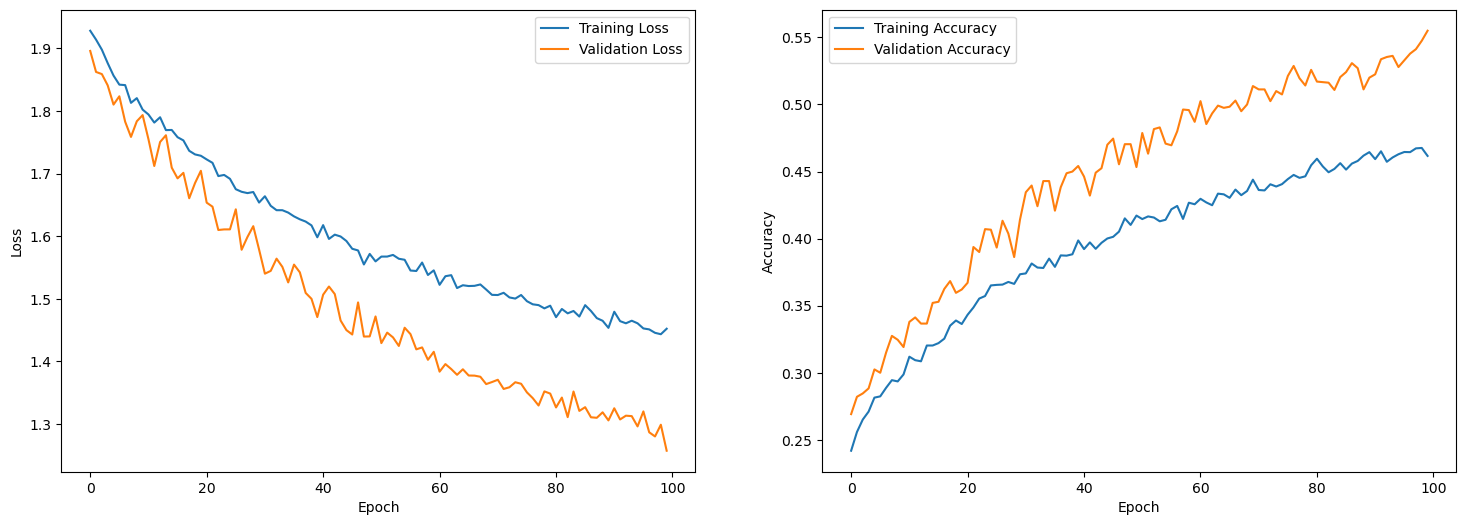

In [30]:
# callbacks
es = keras.callbacks.EarlyStopping(
    monitor="val_categorical_accuracy", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

# fit the model
network_history = cnn_model.fit( X_train, Y_train, epochs = 100, validation_split = 0.2, callbacks = [es])

# observe the training
plot_network_history(network_history)

In [32]:
# evaluate model
y_pred = np.argmax(cnn_model.predict(X_test), 1)
y_true = np.argmax(Y_test, 1)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1        = f1_score(y_true, y_pred, average='macro', zero_division=0)

cnn = f1 # for future analysis

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

print()
print('Classification Report')
print(classification_report(y_true, y_pred, target_names = emotion_list.values()))

9/9 [==============================] - 0s 2ms/step
Accuracy : 0.4444444444444444
Precision: 0.4094743836872773
Recall   : 0.40973203278527015
F1 Score : 0.37997402041498507

Classification Report
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        20
        calm       0.41      0.80      0.54        40
       happy       0.33      0.62      0.43        34
         sad       0.47      0.18      0.26        38
       angry       0.74      0.44      0.55        39
     fearful       0.36      0.30      0.33        33
   disgusted       0.43      0.26      0.33        38
   surprised       0.53      0.67      0.60        46

    accuracy                           0.44       288
   macro avg       0.41      0.41      0.38       288
weighted avg       0.44      0.44      0.41       288



C:\Users\ogiev\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ogiev\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ogiev\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


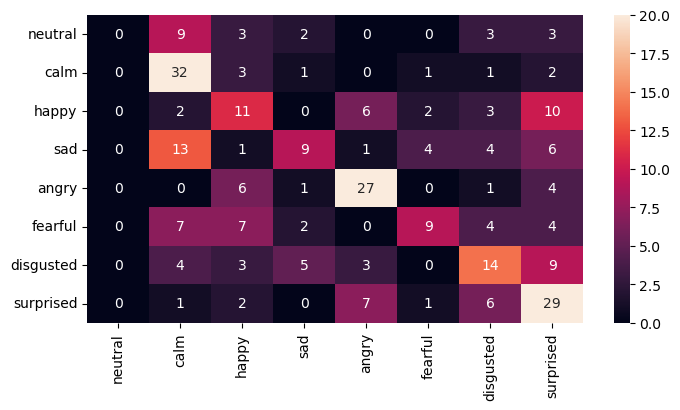

In [19]:
# confusion matrix
plt.figure(figsize=(8, 4))
conf   = confusion_matrix(y_true, y_pred)
labels = emotion_list.values()
sns.heatmap(conf, annot=True, fmt="d", vmax=20, xticklabels = labels, yticklabels = labels)
plt.show()

---
## Long Short Term Memory Network

LSTM networks are a type of recurrent neural network (RNN). Because of the conventional nature of this model in solving sequence prediction problems, like text, speech and video classifications, we expect a marked improvement in performance.

In [20]:
lstm_model = Sequential()

layers = [
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(1024),
    Dense(num_classes, activation="softmax"),
]

lstm_model = tf.keras.Sequential(layers)
lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              4202496   
                                                                 
 dense_8 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 4210696 (16.06 MB)
Trainable params: 4210696 (16.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/100
150/150 [==============================] - 73s 485ms/step - loss: 0.4881 - accuracy: 0.8235 - val_loss: 0.8791 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 2/100
150/150 [==============================] - 73s 490ms/step - loss: 0.4077 - accuracy: 0.8582 - val_loss: 0.8346 - val_accuracy: 0.7237 - lr: 0.0010
Epoch 3/100
150/150 [==============================] - 73s 486ms/step - loss: 0.3531 - accuracy: 0.8767 - val_loss: 0.9044 - val_accuracy: 0.7217 - lr: 0.0010
Epoch 4/100
150/150 [==============================] - 72s 480ms/step - loss: 0.3103 - accuracy: 0.8915 - val_loss: 0.8525 - val_accuracy: 0.7362 - lr: 0.0010
Epoch 5/100
150/150 [==============================] - 74s 497ms/step - loss: 0.2834 - accuracy: 0.9043 - val_loss: 0.8909 - val_accuracy: 0.7275 - lr: 0.0010
Epoch 6/100
150/150 [==============================] - 66s 440ms/step - loss: 0.2276 - accuracy: 0.9251 - val_loss: 0.9013 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 7/100
150/150 [=========================

150/150 [==============================] - 63s 419ms/step - loss: 1.1625e-04 - accuracy: 1.0000 - val_loss: 1.2533 - val_accuracy: 0.7917 - lr: 5.0000e-04
Epoch 51/100
150/150 [==============================] - ETA: 0s - loss: 1.0610e-04 - accuracy: 1.0000
Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
150/150 [==============================] - 64s 424ms/step - loss: 1.0610e-04 - accuracy: 1.0000 - val_loss: 1.2617 - val_accuracy: 0.7917 - lr: 5.0000e-04
Epoch 52/100
150/150 [==============================] - 64s 428ms/step - loss: 9.7567e-05 - accuracy: 1.0000 - val_loss: 1.2656 - val_accuracy: 0.7912 - lr: 2.5000e-04
Epoch 53/100
150/150 [==============================] - 63s 418ms/step - loss: 9.3218e-05 - accuracy: 1.0000 - val_loss: 1.2694 - val_accuracy: 0.7917 - lr: 2.5000e-04
Epoch 54/100
150/150 [==============================] - 64s 425ms/step - loss: 8.8905e-05 - accuracy: 1.0000 - val_loss: 1.2733 - val_accuracy: 0.7912 - lr: 2.5000e-04


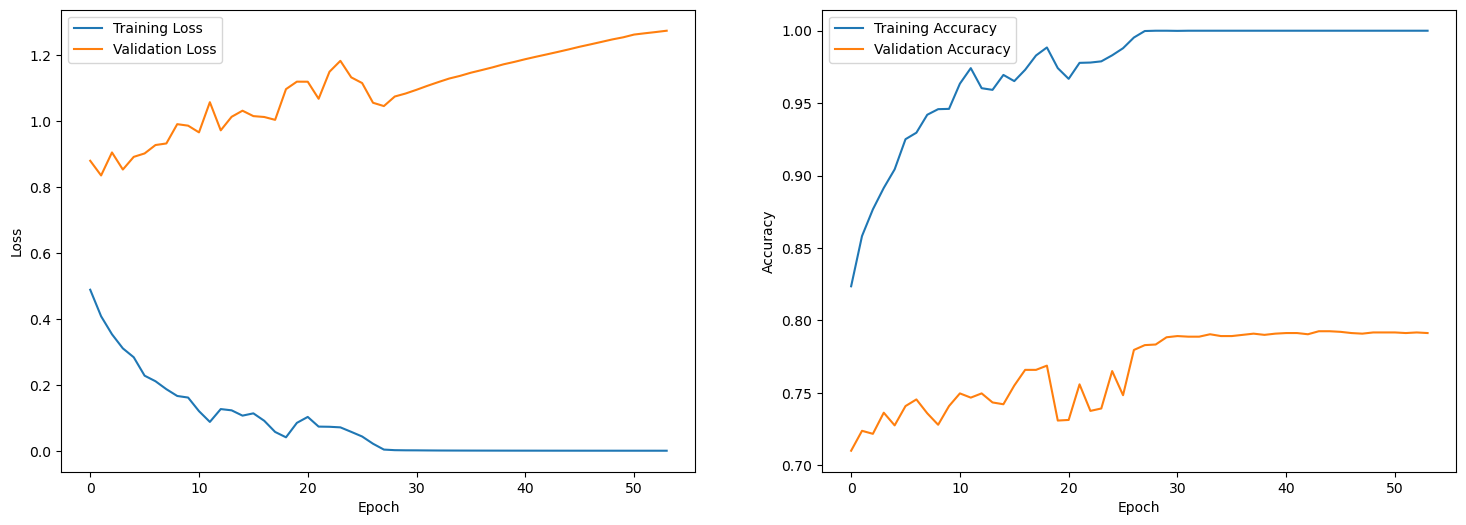

In [23]:
# callbacks
es = keras.callbacks.EarlyStopping( 
        monitor = "val_categorical_accuracy", 
        min_delta = 0.01, 
        patience = 10, 
        restore_best_weights = True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor  = "val_categorical_accuracy",
        factor   = 0.5,
        patience = 7,
        min_lr   = 1e-7,
        verbose  = 1,
)


# fit the model
network_history = lstm_model.fit(
    X_train,
    Y_train,
    epochs = 100,
    batch_size = 128,
    validation_split = 0.2,
    callbacks = [es, lr_scheduler],
)

# observe the training
plot_network_history(network_history)

In [25]:
# evaluate model
y_pred = np.argmax(lstm_model.predict(X_test), 1)
y_true = np.argmax(Y_test, 1)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

lstm = f1 # for future analysis

print()
print('Classification Report')
print(classification_report(y_true, y_pred, target_names = emotion_list.values()))

9/9 [==============================] - 1s 58ms/step
Accuracy : 0.5381944444444444
Precision: 0.5393089800306956
Recall   : 0.5345808845493359
F1 Score : 0.5289025499866344

Classification Report
              precision    recall  f1-score   support

     neutral       0.48      0.70      0.57        20
        calm       0.71      0.75      0.73        40
       happy       0.41      0.47      0.44        34
         sad       0.62      0.42      0.50        38
       angry       0.54      0.56      0.55        39
     fearful       0.62      0.45      0.53        33
   disgusted       0.57      0.53      0.55        38
   surprised       0.48      0.54      0.51        46

    accuracy                           0.55       288
   macro avg       0.55      0.55      0.55       288
weighted avg       0.56      0.55      0.55       288



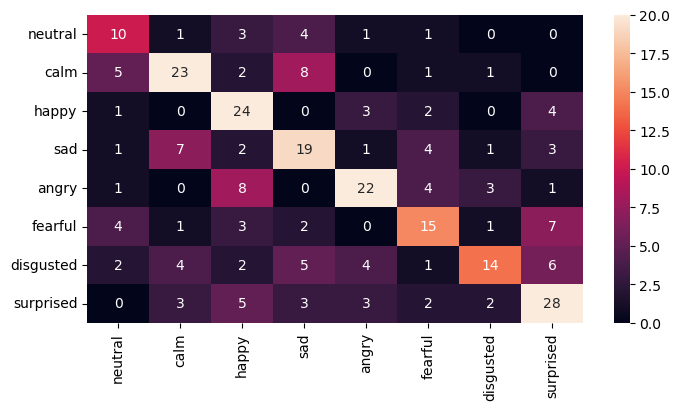

In [26]:
# confusion matrix
plt.figure(figsize=(8, 4))
conf   = confusion_matrix(y_true, y_pred)
labels = emotion_list.values()
sns.heatmap(conf, annot=True, fmt="d", vmax=20, xticklabels=labels, yticklabels=labels)
plt.show()

---
## Combined (CNN + LSTM) Neural Network  
Leveraging the strengths of both the LSTM and CNN architectures in a single model might prove valuable in capturing both the textural and temporal nuances of speech.

In [36]:
comb_model = Sequential()

layers = [
    Input(shape=(X_train.shape[1], X_train.shape[2])),
     
    Conv1D(filters=200, kernel_size=3),
    BatchNormalization(),
    MaxPool1D(pool_size=2, padding="same"),
    Dropout(0.3),
    
    Conv1D(filters=200, kernel_size=3),
    BatchNormalization(),
    Dropout(0.3),
    
    Conv1D(filters=200, kernel_size=3),
    BatchNormalization(),
    MaxPool1D(pool_size=2, padding="same"),
    Dropout(0.3),
    
    LSTM(1024),
    
    Dense(128, activation="relu"),
    BatchNormalization(),
    
    Dense(num_classes, activation="softmax"),
]

comb_model = tf.keras.Sequential(layers)
comb_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

comb_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 38, 200)           800       
                                                                 
 batch_normalization_7 (Bat  (None, 38, 200)           800       
 chNormalization)                                                
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 19, 200)           0         
 ng1D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 19, 200)           0         
                                                                 
 conv1d_17 (Conv1D)          (None, 17, 200)           120200    
                                                                 
 batch_normalization_8 (Bat  (None, 17, 200)         

Epoch 1/100
150/150 [==============================] - 22s 128ms/step - loss: 1.9064 - categorical_accuracy: 0.2760 - val_loss: 1.9458 - val_categorical_accuracy: 0.3021 - lr: 0.0010
Epoch 2/100
150/150 [==============================] - 19s 128ms/step - loss: 1.6819 - categorical_accuracy: 0.3647 - val_loss: 1.6692 - val_categorical_accuracy: 0.3850 - lr: 0.0010
Epoch 3/100
150/150 [==============================] - 20s 133ms/step - loss: 1.5536 - categorical_accuracy: 0.4153 - val_loss: 1.5757 - val_categorical_accuracy: 0.4083 - lr: 0.0010
Epoch 4/100
150/150 [==============================] - 20s 136ms/step - loss: 1.4679 - categorical_accuracy: 0.4517 - val_loss: 1.5708 - val_categorical_accuracy: 0.4425 - lr: 0.0010
Epoch 5/100
150/150 [==============================] - 20s 136ms/step - loss: 1.3725 - categorical_accuracy: 0.4814 - val_loss: 1.2954 - val_categorical_accuracy: 0.5083 - lr: 0.0010
Epoch 6/100
150/150 [==============================] - 20s 136ms/step - loss: 1.2675 

150/150 [==============================] - 21s 139ms/step - loss: 0.2587 - categorical_accuracy: 0.9087 - val_loss: 0.7064 - val_categorical_accuracy: 0.7837 - lr: 0.0010
Epoch 19/100
150/150 [==============================] - 21s 138ms/step - loss: 0.2181 - categorical_accuracy: 0.9245 - val_loss: 0.7081 - val_categorical_accuracy: 0.8021 - lr: 0.0010
Epoch 20/100
150/150 [==============================] - 20s 136ms/step - loss: 0.1896 - categorical_accuracy: 0.9354 - val_loss: 0.7129 - val_categorical_accuracy: 0.8037 - lr: 0.0010
Epoch 21/100
150/150 [==============================] - 20s 135ms/step - loss: 0.1755 - categorical_accuracy: 0.9360 - val_loss: 0.7552 - val_categorical_accuracy: 0.7962 - lr: 0.0010
Epoch 22/100
150/150 [==============================] - 21s 137ms/step - loss: 0.1604 - categorical_accuracy: 0.9443 - val_loss: 0.7878 - val_categorical_accuracy: 0.7962 - lr: 0.0010
Epoch 23/100
150/150 [==============================] - 22s 148ms/step - loss: 0.1486 - categ

KeyError: 'accuracy'

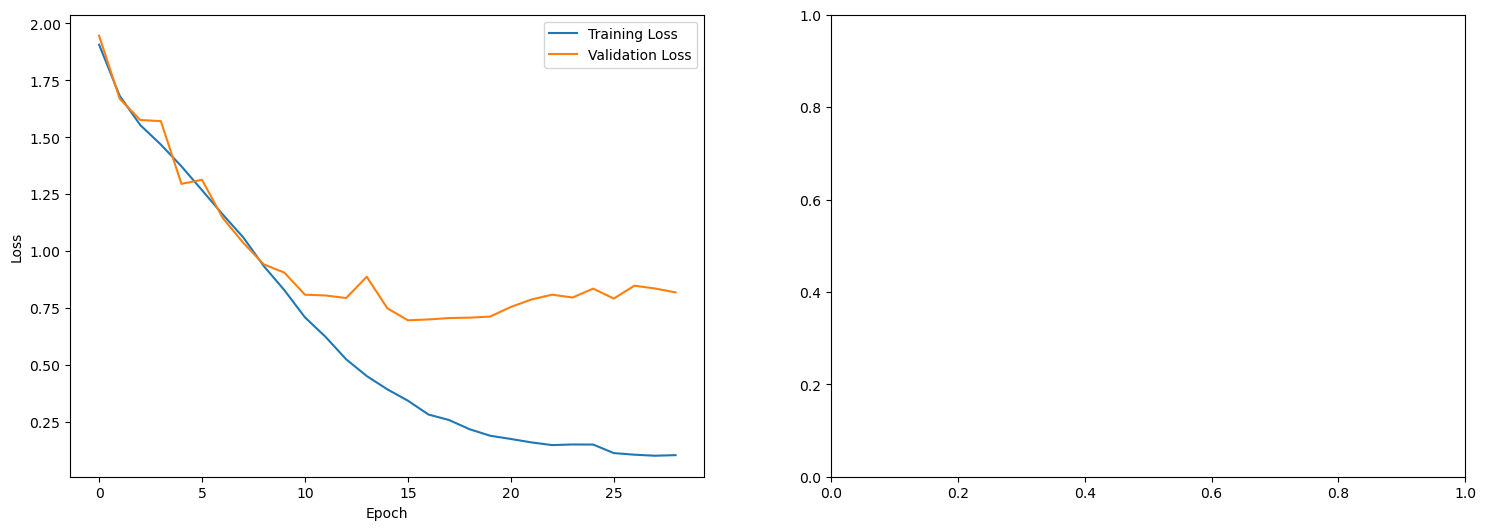

In [37]:
# callbacks
es = keras.callbacks.EarlyStopping( 
        monitor = "val_categorical_accuracy", 
        min_delta = 0.01, 
        patience = 10, 
        restore_best_weights = True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor  = "val_categorical_accuracy",
        factor   = 0.5,
        patience = 7,
        min_lr   = 1e-7,
        verbose  = 1,
)

# fit the model
network_history = comb_model.fit( 
    X_train,
    Y_train,
    epochs = 100,
    batch_size = 64,
    validation_split = 0.2,
    callbacks=[es, lr_scheduler],
)

# observe the training
plot_network_history(network_history)

In [38]:
# evaluate model
y_pred = np.argmax(comb_model.predict(X_test), 1)
y_true = np.argmax(Y_test, 1)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

combo = f1 # for future analysis

print()
print('Classification Report')
print(classification_report(y_true, y_pred, target_names = emotion_list.values()))

9/9 [==============================] - 1s 33ms/step
Accuracy : 0.5902777777777778
Precision: 0.5936540573646025
Recall   : 0.5804212963529494
F1 Score : 0.5810747647473894

Classification Report
              precision    recall  f1-score   support

     neutral       0.53      0.45      0.49        20
        calm       0.78      0.80      0.79        40
       happy       0.53      0.56      0.54        34
         sad       0.46      0.68      0.55        38
       angry       0.79      0.67      0.72        39
     fearful       0.51      0.55      0.53        33
   disgusted       0.58      0.39      0.47        38
   surprised       0.57      0.54      0.56        46

    accuracy                           0.59       288
   macro avg       0.59      0.58      0.58       288
weighted avg       0.60      0.59      0.59       288



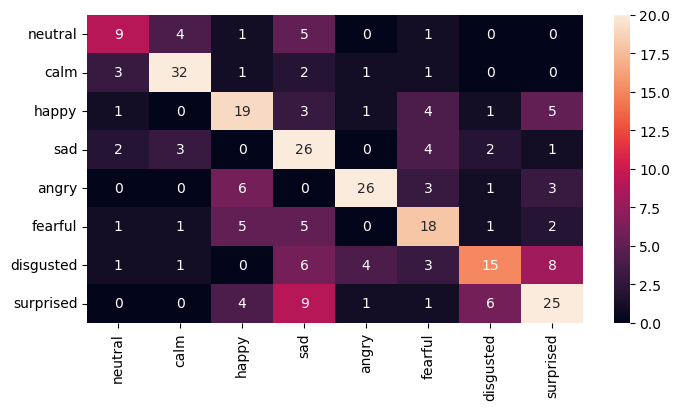

In [39]:
# confusion matrix
plt.figure(figsize=(8, 4))
conf   = confusion_matrix(y_true, y_pred)
labels = emotion_list.values()
sns.heatmap(conf, annot=True, fmt="d", vmax=20, xticklabels=labels, yticklabels=labels)
plt.show()

---
**Bi-directional Long Short Term Neural Network**

Bidirectional LSTMs are an extension of traditional LSTMs which provide additional context to the network. In a Bi-LSTM, input data is processed in both forward and backward directions (two LSTMs), which means that the network has information from past (backward) and future (forward) states simultaneously.

In [40]:
bi_model = Sequential()

layers = [
    Input(shape=(X_train.shape[1], X_train.shape[2])),
     
    Bidirectional(LSTM(1024, return_sequences=True)),
    Bidirectional(LSTM(1024)),
    
    Dense(num_classes, activation="softmax"),
]

bi_model = tf.keras.Sequential(layers)
bi_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

bi_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 40, 2048)          8404992   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 2048)              25174016  
 onal)                                                           
                                                                 
 dense_15 (Dense)            (None, 8)                 16392     
                                                                 
Total params: 33595400 (128.16 MB)
Trainable params: 33595400 (128.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
# callbacks
es = keras.callbacks.EarlyStopping( 
        monitor = "val_categorical_accuracy", 
        min_delta = 0.01, 
        patience = 10, 
        restore_best_weights = True
)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor  = "val_categorical_accuracy",
        factor   = 0.5,
        patience = 7,
        min_lr   = 1e-7,
        verbose  = 1,
)

# fit the model
network_history = bi_model.fit( 
    X_train,
    Y_train,
    epochs = 100,
    batch_size = 64,
    validation_split = 0.2,
    callbacks=[es, lr_scheduler],
)

# observe the training
plot_network_history(network_history)

Epoch 1/100
150/150 [==============================] - 487s 3s/step - loss: 1.8028 - categorical_accuracy: 0.3129 - val_loss: 1.6103 - val_categorical_accuracy: 0.3854 - lr: 0.0010
Epoch 2/100
150/150 [==============================] - 481s 3s/step - loss: 1.5341 - categorical_accuracy: 0.4197 - val_loss: 1.4361 - val_categorical_accuracy: 0.4754 - lr: 0.0010
Epoch 3/100
  5/150 [>.............................] - ETA: 7:17 - loss: 1.3682 - categorical_accuracy: 0.4844

KeyboardInterrupt: 

In [ ]:
# evaluate model
y_pred = np.argmax(bi_model.predict(X_test), 1)
y_true = np.argmax(Y_test, 1)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

bi = f1 # for future analysis

print()
print('Classification Report')
print(classification_report(y_test_labels, y_pred_labels, target_names = emotion_list.values()))

In [ ]:
# confusion matrix
plt.figure(figsize=(8, 4))
conf   = confusion_matrix(y_true, y_pred)
labels = emotion_list.values()
sns.heatmap(conf, annot=True, fmt="d", vmax=20, xticklabels=labels, yticklabels=labels)
plt.show()

In [42]:
bi = 72

**Comparing the Models**

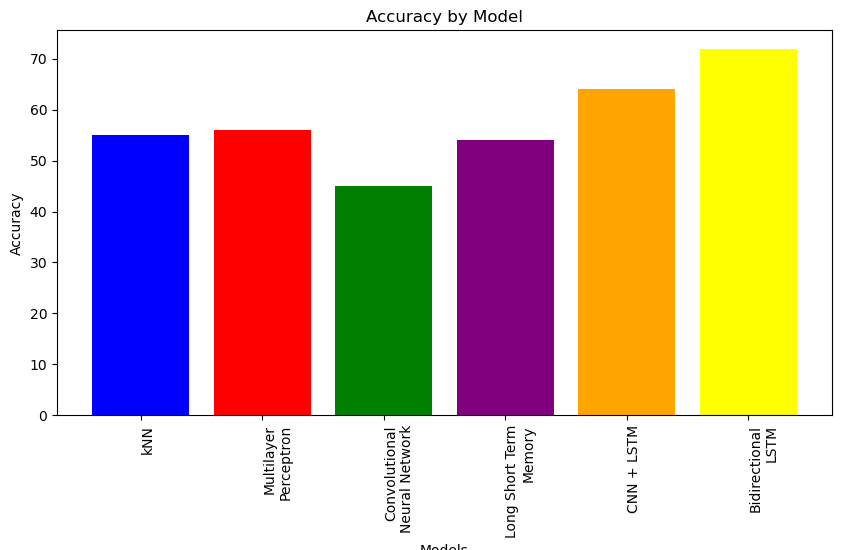

In [54]:
f1_scores = [55, 56, 45, 54, 64, 72]
models = ['kNN', 'Multilayer Perceptron', 'Convolutional Neural Network', 'Long Short Term Memory', 'CNN + LSTM', 'Bidirectional LSTM']
colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow']

plt.figure(figsize=(10, 5))
plt.bar(models, f1_scores, color=colors)
plt.title('Accuracy by Model')
plt.xlabel('Models')
plt.ylabel('Accuracy')
# plt.xticks(rotation = 20)
plt.xticks(ticks=range(len(models)), labels=models, rotation=90, ha='right')
plt.gca().set_xticklabels(models, wrap=True)

plt.show()
